# Medical Diagnosis(Classification) with Heartbeat Sounds 

## Context
This dataset was originally for a machine learning challenge to classify heart beat sounds. The data was gathered from two sources: (A) from the general public via the iStethoscope Pro iPhone app, and (B) from a clinic trial in hospitals using the digital stethoscope DigiScope.

importing required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import IPython.display as ipd
from librosa.core import stft, amplitude_to_db
import librosa.display
from tqdm import tqdm
import librosa as lr
from sklearn import preprocessing
from pycaret.classification import *

import warnings
warnings.filterwarnings("ignore")

Combining sets a and b.

In [3]:
df = []
for folder in ["set_a/**","set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                df.append({
                    "filename": filename,
                    "label": label
                })
df = pd.DataFrame(df)
df

,filename,label
0,set_a\artifact__201012172012.wav,artifact
1,set_a\artifact__201105040918.wav,artifact
2,set_a\artifact__201105041959.wav,artifact
3,set_a\artifact__201105051017.wav,artifact
4,set_a\artifact__201105060108.wav,artifact
...,...,...
580,set_b\normal__296_1311682952647_A1.wav,normal
581,set_b\normal__296_1311682952647_A2.wav,normal
582,set_b\normal__298_1311685888900_B.wav,normal
583,set_b\normal__299_1311770522820_C.wav,normal


Showing vawe plots and spectrograms with one sample from each 5 groups.

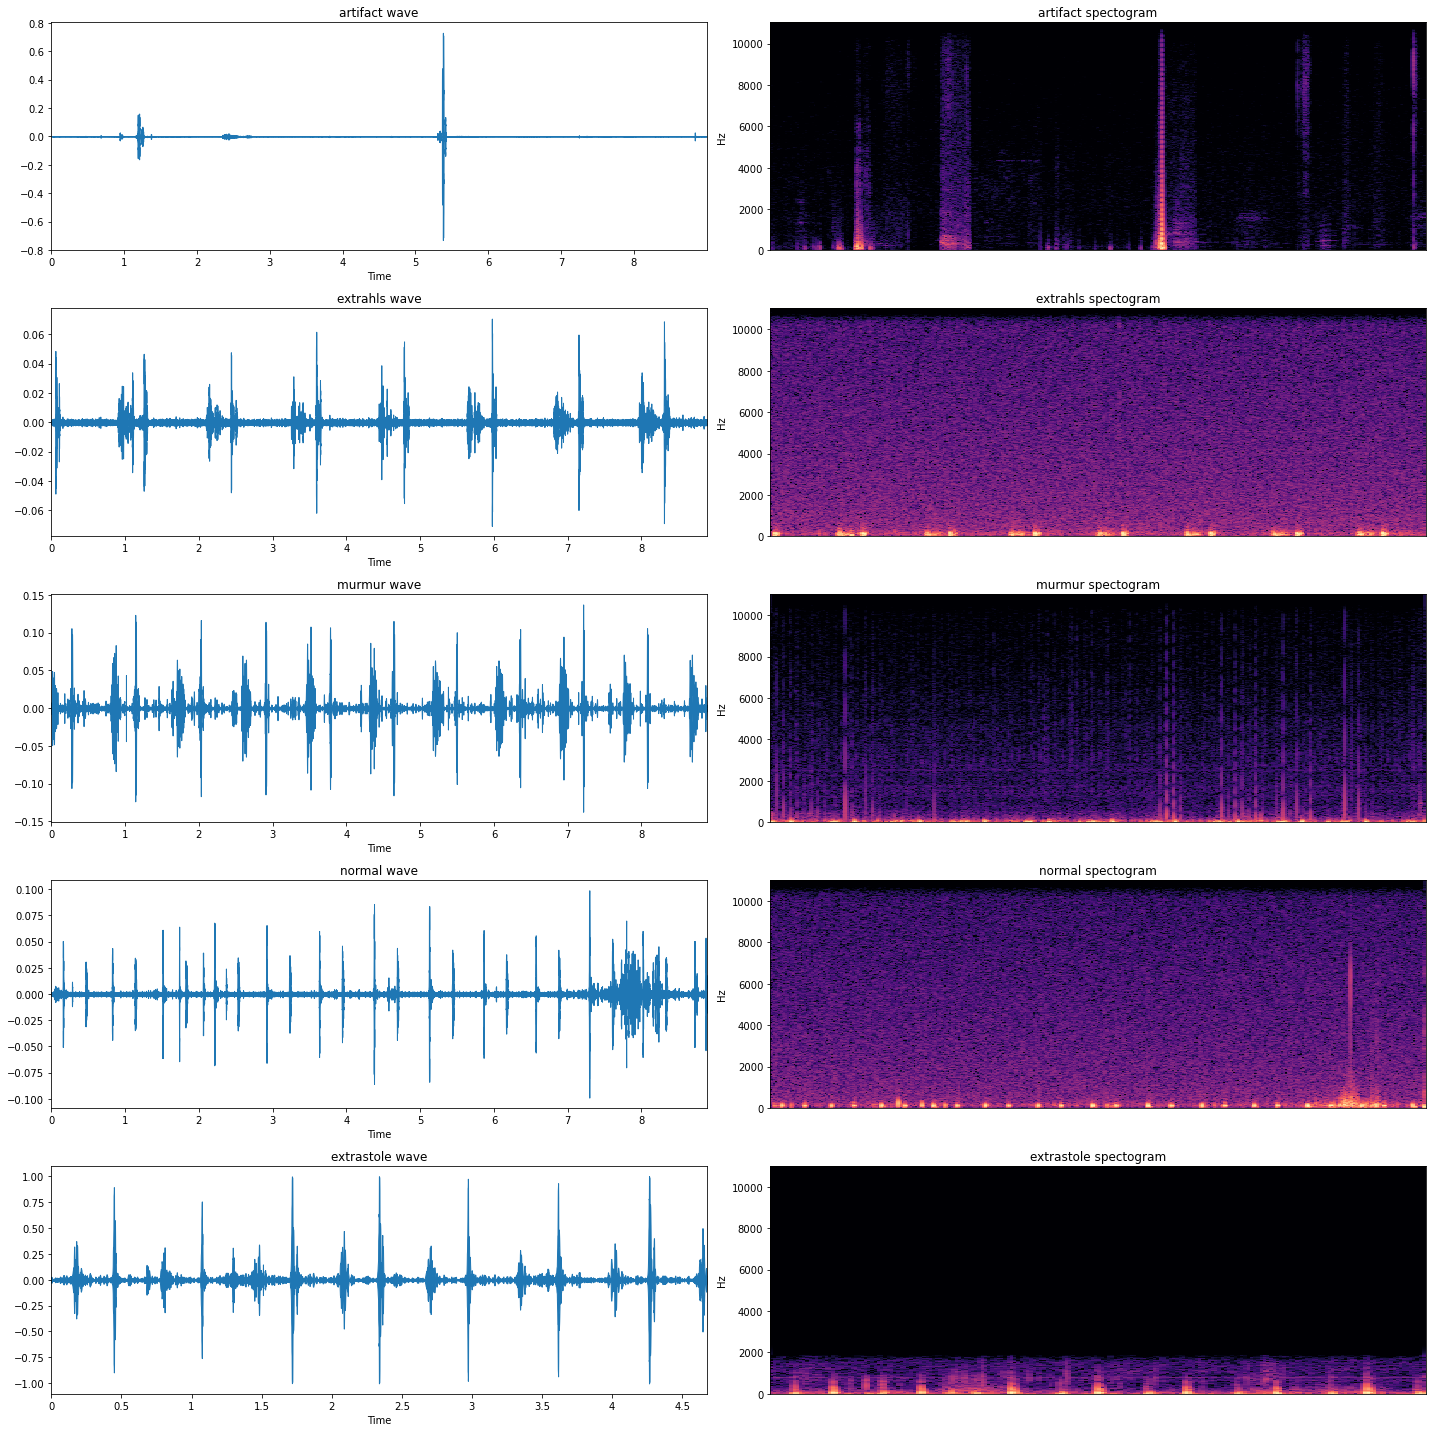

In [4]:
plt.figure(figsize=(20,20))
idx = 0
for label in df.label.unique():
    y, sr = lr.load(df[df.label==label].filename.iloc[0])
    idx+=1
    plt.subplot(5, 2, idx)
    plt.title("%s wave" % label)
    lr.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 2, idx)
    D = lr.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    lr.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    plt.tight_layout()
plt.show()

Sound processing and feature extraction.

In [5]:
df['mean'] = pd.Series()
df['std'] = pd.Series()
df['max_val'] = pd.Series()
df['mean bandwith'] = pd.Series()
df['std bandwith'] = pd.Series()
df['max_val bandwith'] = pd.Series()
df['mean centroid'] = pd.Series()
df['std centroid'] = pd.Series()
df['max_val centroid'] = pd.Series()
df['mean rolloff'] = pd.Series()
df['std rolloff'] = pd.Series()
df['max_val rolloff'] = pd.Series()
df['mean flatness'] = pd.Series()
df['std flatness'] = pd.Series()
df['max_val flatness'] = pd.Series()
    
for i in tqdm(range(0,len(df))):  
            
    audio, sfreq = lr.load(df['filename'].iloc[i])
    time = np.arange(0,len(audio))/sfreq
    
    audio = pd.Series(audio)
    audio_rectified = audio.apply(np.abs)
    audio_rectified_smooth = audio_rectified.rolling(25).mean()
    
    mean = np.mean(audio_rectified_smooth, axis=0)
    std = np.std(audio_rectified_smooth, axis=0)
    max_val = np.max(audio_rectified_smooth, axis=0)
    
    df['mean'].iloc[i] = mean
    df['std'].iloc[i] = std
    df['max_val'].iloc[i] = max_val    
    
    HOP_LENGTH = 2**4
    N_FFT=2**7
    audio = np.asarray(audio)
    spec = stft(audio, hop_length=HOP_LENGTH, n_fft=N_FFT)
    spec = np.array(np.abs(spec))
    
    bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
    centroids = lr.feature.spectral_centroid(S=spec)[0]
    rolloff = lr.feature.spectral_rolloff(S=spec)[0]
    flatness = lr.feature.spectral_flatness(S=spec, n_fft=N_FFT, hop_length=HOP_LENGTH)
   
    df['mean bandwith'].iloc[i] = np.mean(bandwidths)
    df['std bandwith'].iloc[i] = np.std(bandwidths)
    df['max_val bandwith'].iloc[i] = np.max(bandwidths)
    df['mean centroid'].iloc[i] = np.mean(centroids)
    df['std centroid'].iloc[i] = np.std(centroids)
    df['max_val centroid'].iloc[i] = np.max(centroids)
    df['mean rolloff'].iloc[i] = np.mean(rolloff)
    df['std rolloff'].iloc[i] = np.std(rolloff)
    df['max_val rolloff'].iloc[i] = np.max(rolloff)  
    df['mean flatness'].iloc[i] = np.mean(flatness)
    df['std flatness'].iloc[i] = np.std(flatness)
    df['max_val flatness'].iloc[i] = np.max(flatness)

100%|██████████| 585/585 [02:52<00:00,  3.39it/s]


In [6]:
df

,filename,label,mean,std,max_val,mean bandwith,std bandwith,max_val bandwith,mean centroid,std centroid,max_val centroid,mean rolloff,std rolloff,max_val rolloff,mean flatness,std flatness,max_val flatness
0,set_a\artifact__201012172012.wav,artifact,0.001307,0.013021,0.499050,2780.312786,365.603450,4039.207969,3692.964245,1011.359380,8028.485574,7055.210611,1582.659266,10508.203125,0.252319,0.126474,0.586538
1,set_a\artifact__201105040918.wav,artifact,0.000296,0.000650,0.011893,2592.266829,187.700607,3455.674611,5166.850386,2199.808094,8273.594892,7895.193020,1889.645866,10335.937500,0.206246,0.084462,0.565123
2,set_a\artifact__201105041959.wav,artifact,0.000480,0.000675,0.012003,2933.511405,219.449949,3779.878019,4113.774703,755.048787,7762.444234,7762.910685,880.068490,9819.140625,0.280967,0.091582,0.584639
3,set_a\artifact__201105051017.wav,artifact,0.010057,0.010801,0.360011,2145.907417,459.965599,3982.636619,1970.582319,772.466516,6361.889364,4039.478917,1727.316908,9819.140625,0.042755,0.065074,0.500275
4,set_a\artifact__201105060108.wav,artifact,0.012596,0.030995,0.658184,2406.646717,363.582494,3663.498263,2277.788017,605.435448,4892.210054,4788.148323,1451.659952,9302.343750,0.058881,0.054826,0.505979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,set_b\normal__296_1311682952647_A1.wav,normal,0.083512,0.152345,0.996440,358.168385,129.412997,1686.474149,253.113243,139.178799,837.946224,504.024329,363.581636,1550.390625,0.000006,0.000095,0.002126
581,set_b\normal__296_1311682952647_A2.wav,normal,0.087430,0.151074,1.000006,353.163439,117.931403,1853.815403,244.238571,128.361727,918.994375,480.604919,325.793994,1722.656250,0.000004,0.000085,0.003099
582,set_b\normal__298_1311685888900_B.wav,normal,0.034306,0.075804,0.993511,411.676418,100.202940,1428.177941,343.237645,157.902090,1086.578023,711.393901,362.560567,1722.656250,0.000002,0.000044,0.003166
583,set_b\normal__299_1311770522820_C.wav,normal,0.039000,0.073645,0.797694,428.500307,107.190585,1676.131215,357.795813,180.260146,1398.270091,771.739177,392.914139,1894.921875,0.000003,0.000128,0.008268


There will be two versions, normal and non-normal inspect or 5 classes inspect. we will see the results.

In [7]:
df_multiclass = df.copy()
df_binary = df.copy()
df_binary['label'] = np.where(df_binary['label'].str.contains('normal', case=False, na = False), 1, 0)

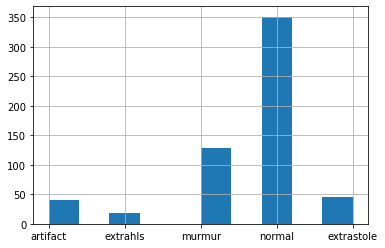

In [8]:
df_multiclass.label.hist();

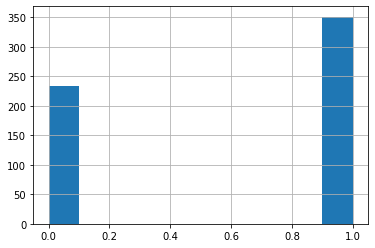

In [9]:
df_binary.label.hist();

In [10]:
df_multiclass = df_multiclass.drop('filename', axis=1)
df_binary = df_binary.drop('filename', axis=1)

encoding for one variable(target)

In [11]:
lbl = preprocessing.LabelEncoder() 
lbl.fit(list(df_multiclass['label'].values)) 
df_multiclass['label'] = lbl.transform(list(df_multiclass['label'].values))

lbl = preprocessing.LabelEncoder() 
lbl.fit(list(df_binary['label'].values)) 
df_binary['label'] = lbl.transform(list(df_binary['label'].values))

Pycaret Auto-ML Results 

In [25]:
clf = setup(data = df_binary, 
             target = 'label', train_size = 0.8, fold=10, normalize= True, data_split_stratify= True,
             remove_outliers = True, outliers_threshold =0.1, silent = True)

,Description,Value
0,session_id,975
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(585, 16)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7555,0.7222,0.9326,0.7481,0.8294,0.4154,0.4513,0.0070
ridge,Ridge Classifier,0.7483,0.0000,0.9400,0.7389,0.8263,0.3916,0.4384,0.0050
lr,Logistic Regression,0.7482,0.7047,0.9326,0.7408,0.8250,0.3959,0.4356,0.0070
lda,Linear Discriminant Analysis,0.7482,0.6944,0.9437,0.7373,0.8268,0.3891,0.4390,0.0070
et,Extra Trees Classifier,0.7481,0.7513,0.9140,0.7494,0.8218,0.4015,0.4360,0.0610
ada,Ada Boost Classifier,0.7435,0.7231,0.9026,0.7551,0.8190,0.3857,0.4115,0.0280
gbc,Gradient Boosting Classifier,0.7339,0.7346,0.8761,0.7522,0.8074,0.3803,0.3981,0.0380
rf,Random Forest Classifier,0.7315,0.7481,0.8875,0.7438,0.8074,0.3694,0.3947,0.0830
lightgbm,Light Gradient Boosting Machine,0.7268,0.7433,0.8425,0.7593,0.7964,0.3787,0.3887,0.0130
knn,K Neighbors Classifier,0.7173,0.6550,0.8728,0.7355,0.7970,0.3404,0.3577,0.0110


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [27]:
clf = setup(data = df_multiclass, 
             target = 'label', train_size = 0.8, fold=10, normalize= True, data_split_stratify= True,
             remove_outliers = True, outliers_threshold =0.1, silent = True)

,Description,Value
0,session_id,4915
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4"
4,Original Data,"(585, 16)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7102,0.5333,0.4486,0.6445,0.6525,0.3467,0.3894,0.0640
lda,Linear Discriminant Analysis,0.7101,0.4909,0.5385,0.6479,0.6482,0.3457,0.3927,0.0060
lr,Logistic Regression,0.7030,0.4997,0.4459,0.6356,0.6341,0.3084,0.3681,0.0160
rf,Random Forest Classifier,0.6793,0.5174,0.3746,0.5981,0.6252,0.2888,0.3162,0.0720
ridge,Ridge Classifier,0.6745,0.0000,0.3497,0.6091,0.5920,0.2171,0.2812,0.0060
lightgbm,Light Gradient Boosting Machine,0.6722,0.5210,0.3829,0.6230,0.6334,0.2973,0.3144,0.0450
gbc,Gradient Boosting Classifier,0.6603,0.5071,0.3540,0.6026,0.6149,0.2658,0.2841,0.1540
knn,K Neighbors Classifier,0.6482,0.4405,0.4287,0.5944,0.6115,0.2682,0.2800,0.0130
svm,SVM - Linear Kernel,0.6223,0.0000,0.4690,0.5949,0.5949,0.2813,0.2961,0.0090
dt,Decision Tree Classifier,0.5842,0.4417,0.4280,0.5952,0.5832,0.2374,0.2413,0.0060


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=4915, verbose=0,
                     warm_start=False)

In [29]:
et  = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7209,0.7908,0.3052,0.6361,0.6697,0.3929,0.4210
1,0.7381,0.7704,0.4726,0.6601,0.6820,0.3905,0.4346
2,0.7381,0.7082,0.6526,0.6905,0.6803,0.3840,0.4466
3,0.6429,0.8045,0.2252,0.5258,0.5697,0.1393,0.1614
4,0.7143,0.0000,0.3407,0.6422,0.6493,0.2951,0.3620
5,0.8095,0.0000,0.6657,0.7565,0.7691,0.5805,0.6154
6,0.6429,0.0000,0.4105,0.5847,0.5633,0.2174,0.2665
7,0.6905,0.7807,0.2723,0.6564,0.6274,0.2825,0.3551
8,0.7143,0.6941,0.6646,0.6724,0.6663,0.4085,0.4417
9,0.6905,0.7840,0.4769,0.6200,0.6477,0.3760,0.3899


In [30]:
et_tuned = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7209,0.8540,0.4726,0.6854,0.6586,0.3614,0.4301
1,0.7381,0.7007,0.2800,0.6596,0.6694,0.3538,0.4327
2,0.7143,0.7050,0.6326,0.6581,0.6432,0.3124,0.3844
3,0.7143,0.7733,0.4400,0.6393,0.6311,0.2871,0.3793
4,0.6667,0.0000,0.5157,0.5708,0.5698,0.1788,0.2392
5,0.6667,0.0000,0.2907,0.5986,0.5875,0.1683,0.2231
6,0.6429,0.0000,0.4105,0.5847,0.5633,0.2174,0.2665
7,0.6429,0.7784,0.2323,0.5770,0.5646,0.1818,0.2294
8,0.6905,0.6325,0.4769,0.6176,0.6471,0.3576,0.3760
9,0.6905,0.8140,0.4523,0.6204,0.6171,0.3053,0.3641


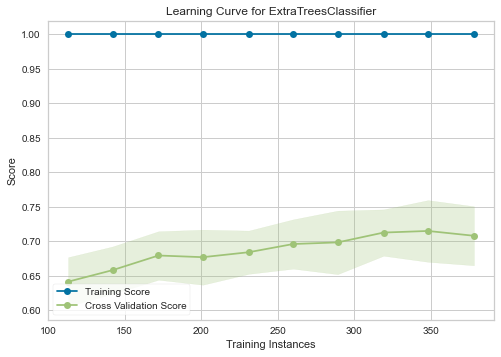

In [31]:
plot_model(estimator = et, plot = 'learning')

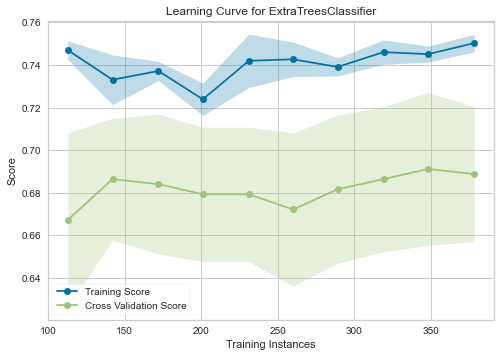

In [32]:
plot_model(estimator = et_tuned, plot = 'learning')

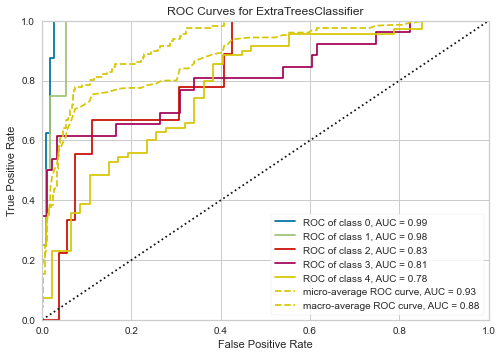

In [33]:
plot_model(estimator = et_tuned, plot = 'auc')

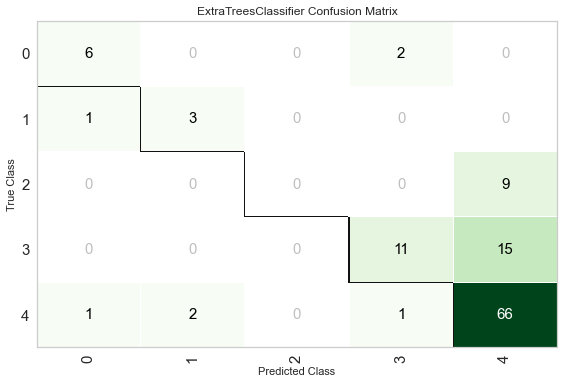

In [34]:
plot_model(estimator = et_tuned, plot = 'confusion_matrix')

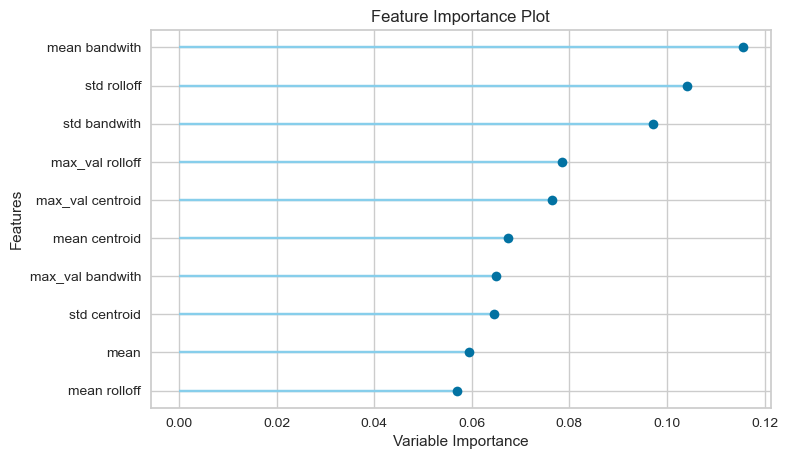

In [35]:
plot_model(estimator = et_tuned, plot = 'feature')

In [36]:
evaluate_model(et_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

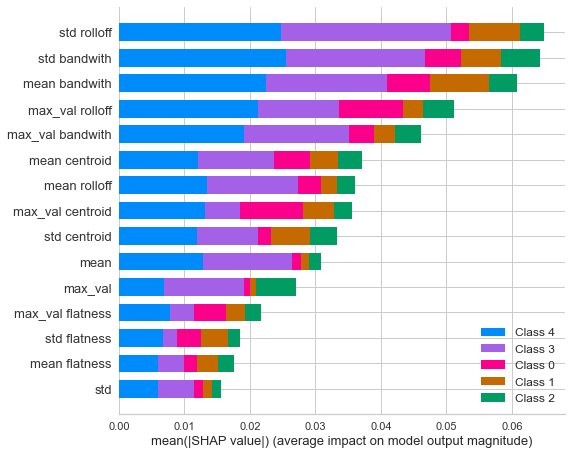

In [39]:
interpret_model(et_tuned)